# Convolutional Neural Network model

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

## Define the transformations for the training and testing data and load the data

In [2]:
TRAIN_DATA_PATH = 'data/train'
TEST_DATA_PATH = 'data/test'

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(90),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.Resize(90),
    transforms.CenterCrop(90),
    transforms.ToTensor()
])
train_data = ImageFolder(root=TRAIN_DATA_PATH, transform=train_transforms)
test_data = ImageFolder(root=TEST_DATA_PATH, transform=test_transforms)

Label :malignant(1)
Label :malignant(1)
Label :malignant(1)
Label :malignant(1)
Label :malignant(1)
Label :malignant(1)


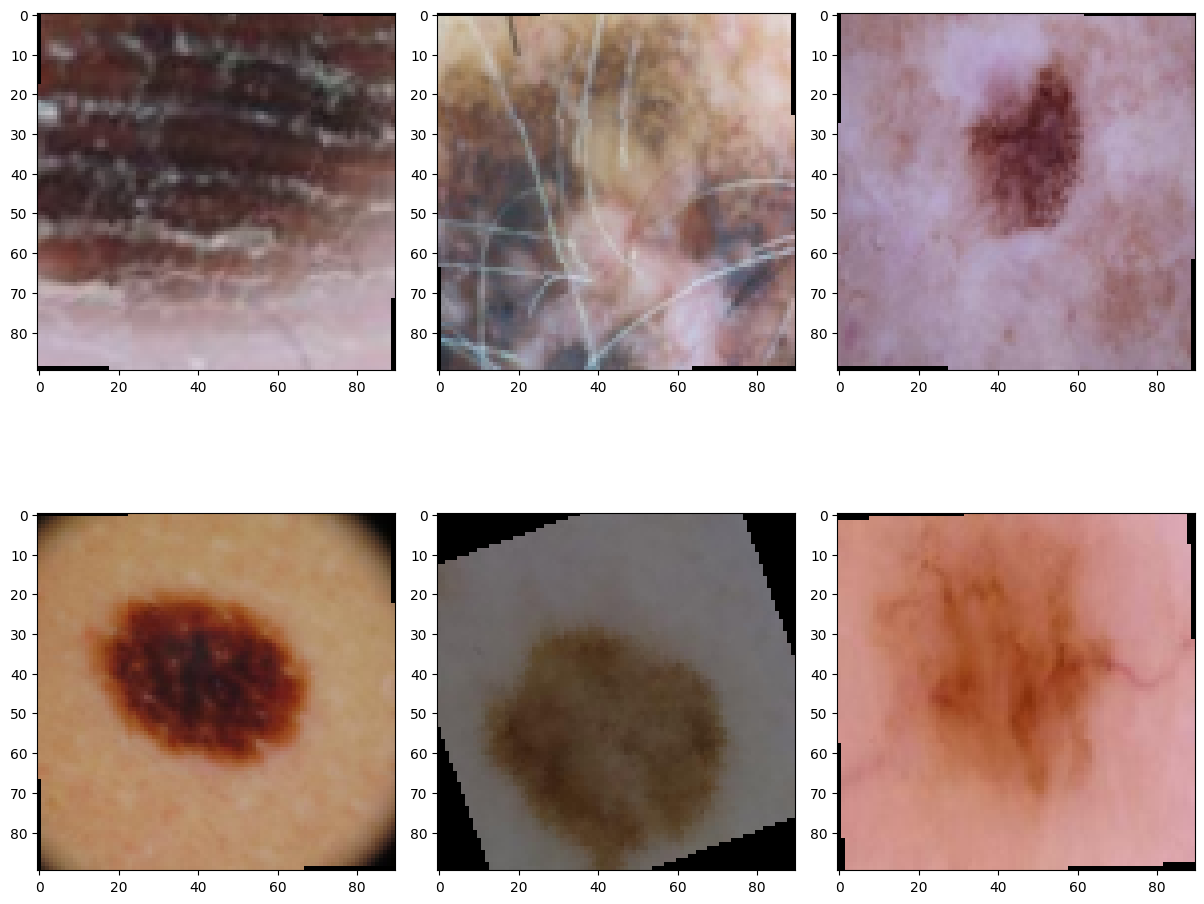

In [3]:
train = ImageFolder(TRAIN_DATA_PATH, transform=transforms.ToTensor())
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    return image.permute(1, 2, 0)

fig, axs = plt.subplots(2, 3,figsize=(12,10))
fig.tight_layout(pad=0)
axs[0,0].imshow(show_image(*train[6000]))
axs[0,1].imshow(show_image(*train[7000]))
axs[1, 0].imshow(show_image(*train[8000]))
axs[1,1].imshow(show_image(*train[9000]))
axs[0,2].imshow(show_image(*train[9500]))
axs[1,2].imshow(show_image(*train[9600]))


## Define the CNN model

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Linear(128*26*26, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 2)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

## Method to check accuracy

In [ ]:
def calculate_accuracy(loader, model, device):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

## Check if GPU is available and use it if possible

In [ ]:
is_cuda_available =  torch.cuda.is_available()
print(f"Using GPU: {is_cuda_available}")
device = torch.device('cuda' if is_cuda_available else 'cpu')

## Setup cross-validation

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=1234)

## Define number of epochs

In [ ]:
NUM_EPOCHS = 25

## Main training loop with cross-validation

In [ ]:
fold = 0

for train_index, val_index in kf.split(np.arange(len(train_data))):
    fold += 1
    print(f'Fold {fold}')
    train_subset = Subset(train_data, train_index)
    val_subset = Subset(train_data, val_index)
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

    model = CNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scaler = torch.cuda.amp.GradScaler()

    train_losses = []
    val_accuracies = []

    # Training loop
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            # Mixed precision
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        val_accuracy = calculate_accuracy(val_loader, model, device)
        val_accuracies.append(val_accuracy)
        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {train_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

## Evaluation on the test set

In [ ]:
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
test_accuracy = calculate_accuracy(test_loader, model)
print(f'Test Accuracy: {test_accuracy:.2f}%')

## Save the model

In [ ]:
PATH = "cnn_model.pt"
torch.save(model, PATH)